In [4]:
import umap
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

PATH_TO_12MUTSPEC = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutstep-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/mutspec12.tsv'
PATH_TO_192MUTSPEC = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutstep-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/mutspec192.tsv'
PATH_TO_METADATA = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutstep-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/mutspecMetaData.tsv'

In [5]:
def chop(l, chunk_size):
    for i in range(0, len(l), chunk_size):
        yield l[i:i + chunk_size]

In [6]:
meta_df = pd.read_csv(PATH_TO_METADATA, sep='\t', index_col=0).sort_values(by='Species')
mutspec12 = pd.read_csv(PATH_TO_12MUTSPEC, sep='\t', index_col=0)
mutspec12 = mutspec12.rename(columns={'MutSpec12inter' : 'MutSpec'})
mutspec12 = mutspec12.sort_values(['Species', 'Mut'])

#removing species with less than 15 total mutations
mut_ammount_df = mutspec12.groupby(mutspec12['Species']).aggregate({'ObsNum' : 'sum'}).reset_index()
less_than_15_total_muts = mut_ammount_df.drop(mut_ammount_df[mut_ammount_df['ObsNum'] > 15].index)['Species'].to_list()
for sp in less_than_15_total_muts:
    mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
    meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)

#removing species with less than 4 mutation types
species = mutspec12['Species'].drop_duplicates().to_list()
obsnum_values = mutspec12['ObsNum'].to_list()
chopped_obsnum =  list(chop(obsnum_values, 12))

species_and_obsnum = {}
for i in range(len(species)):
    species_and_obsnum[species[i]] = chopped_obsnum[i]

less_than_4_mut_types = []
for sp, obsnum_list in species_and_obsnum.items():
    if obsnum_list.count(0) > 8:
        less_than_4_mut_types.append(sp)

for sp in less_than_4_mut_types:
    mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
    meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)

#half-assed way of converting the table into what I need
mutspec_vals = mutspec12['MutSpec'].to_list()
muts = mutspec12['Mut'].to_list()[0:12]
species = mutspec12['Species'].drop_duplicates().to_list() #need to reset after removing species

chopped_values = list(chop(mutspec_vals, 12))
df_prep = {}
for i in range(len(species)):
    df_prep[species[i]] = chopped_values[i]
df = pd.DataFrame(df_prep)
df = df.T
df.columns = muts
df = df.fillna(0)


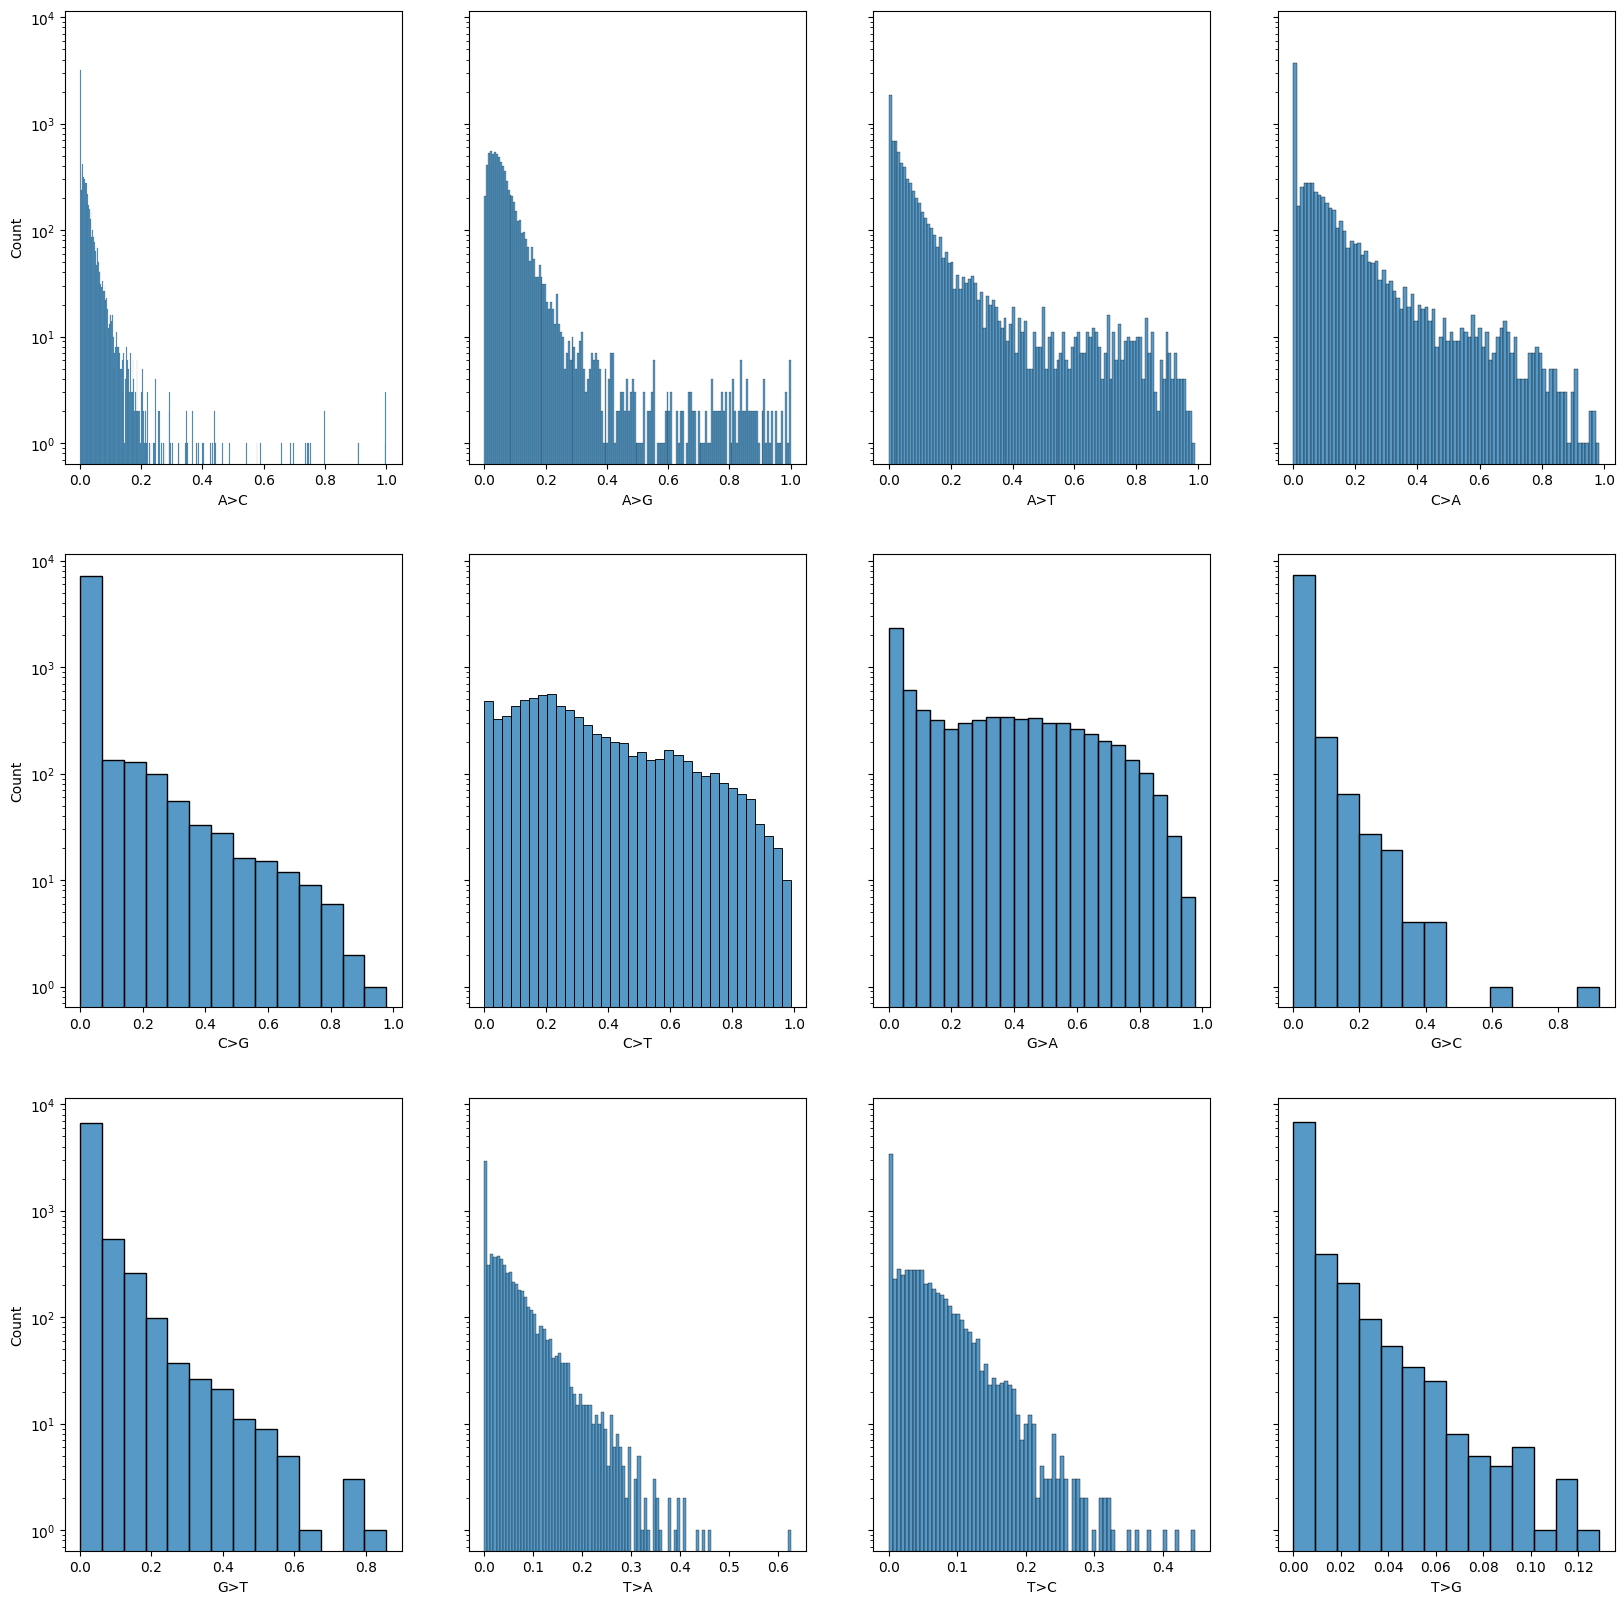

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20,20), sharey=True)
sns.histplot(df, x='A>C', ax=axs[0][0])
sns.histplot(df, x='A>G', ax=axs[0][1])
sns.histplot(df, x='A>T', ax=axs[0][2])
sns.histplot(df, x='C>A', ax=axs[0][3])
sns.histplot(df, x='C>G', ax=axs[1][0])
sns.histplot(df, x='C>T', ax=axs[1][1])
sns.histplot(df, x='G>A', ax=axs[1][2])
sns.histplot(df, x='G>C', ax=axs[1][3])
sns.histplot(df, x='G>T', ax=axs[2][0])
sns.histplot(df, x='T>A', ax=axs[2][1])
sns.histplot(df, x='T>C', ax=axs[2][2])
sns.histplot(df, x='T>G', ax=axs[2][3])
plt.yscale('log')

In [8]:
scaled = preprocessing.scale(df)

In [9]:
pca = PCA()
pca.fit(scaled)
pca_data = pca.transform(scaled)

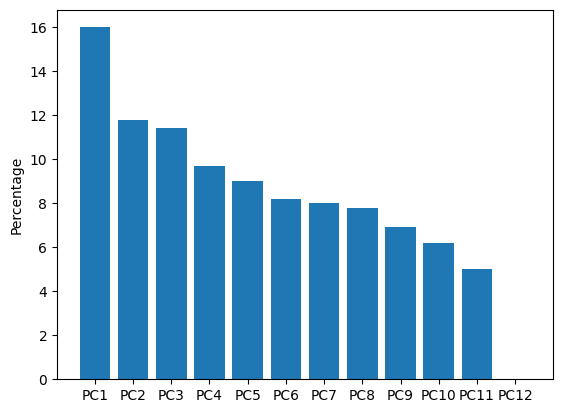

In [10]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage')
plt.show()

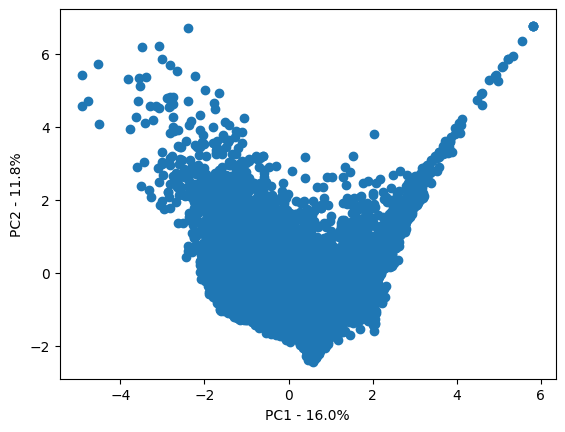

In [11]:
pca_df = pd.DataFrame(pca_data, index=df.index, columns=labels)
pca_df
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

plt.show()

In [12]:
df = df.reset_index() # now I don't have to rerun it all every time, it's required for the cell bellow

In [13]:
# damn, all the renaming brings lots of mess, fix it please
orders = meta_df['Order'].to_list()
df = df.rename(columns={'index':'Species'})
df['Orders'] = orders
reducer = umap.UMAP(random_state=1)
df_data = df[muts].values
scaled_data = preprocessing.StandardScaler().fit_transform(df_data)
embed = reducer.fit_transform(scaled_data)


In [14]:
df

,Species,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,Orders
0,Abagrotis_alternata,0.000000,0.039734,0.893940,0.066326,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,Lepidoptera_7088
1,Abagrotis_nefascia,0.063377,0.077196,0.536850,0.000000,0.000000,0.220241,0.000000,0.000000,0.0,0.000000,0.102336,0.0,Lepidoptera_7088
2,Abagrotis_reedi,0.000000,0.033396,0.013689,0.000000,0.000000,0.045345,0.888857,0.000000,0.0,0.018713,0.000000,0.0,Lepidoptera_7088
3,Abagrotis_variata,0.000000,0.037913,0.161777,0.146494,0.000000,0.470835,0.114481,0.000000,0.0,0.068500,0.000000,0.0,Lepidoptera_7088
4,Abantiades_argentata,0.000000,0.038948,0.000000,0.000000,0.000000,0.180528,0.751433,0.020485,0.0,0.000000,0.008606,0.0,Lepidoptera_7088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7696,Zygaenoprocris_chalcochlora,0.059544,0.142492,0.262823,0.293573,0.090541,0.123283,0.000000,0.000000,0.0,0.027743,0.000000,0.0,Lepidoptera_7088
7697,Zygaenoprocris_persepolis,0.038448,0.124851,0.259567,0.369670,0.000000,0.053881,0.113524,0.000000,0.0,0.040059,0.000000,0.0,Lepidoptera_7088
7698,Zygomyia_notata,0.204730,0.414869,0.000000,0.096123,0.000000,0.225884,0.058394,0.000000,0.0,0.000000,0.000000,0.0,Diptera_7147
7699,Zygothrica_orbitalis,0.076371,0.229123,0.371185,0.000000,0.000000,0.098024,0.109509,0.000000,0.0,0.115788,0.000000,0.0,Diptera_7147


Text(0.5, 1.0, 'UMAP projection of the 12 Mutational spectrum')

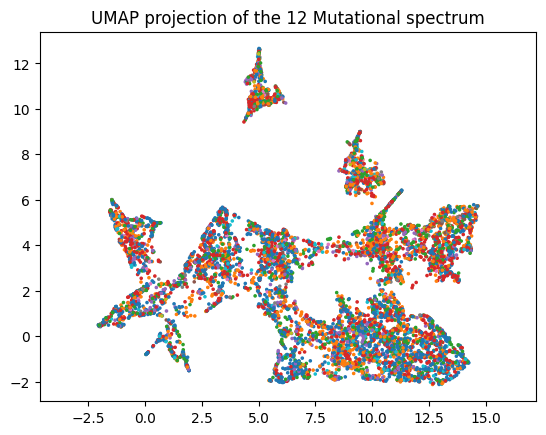

In [15]:
color_per_order = {}
orders = df['Orders'].drop_duplicates().to_list()
for i in range(len(orders)):
    color_per_order[orders[i]] = i
plt.scatter(
    embed[:, 0],
    embed[:, 1],
    c=[sns.color_palette(n_colors=23)[x] for x in df.Orders.map(color_per_order)],
    s=[2.5 for i in range(len(embed[:, 0]))]
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the 12 Mutational spectrum', fontsize=12)

(1.0, 100.0)

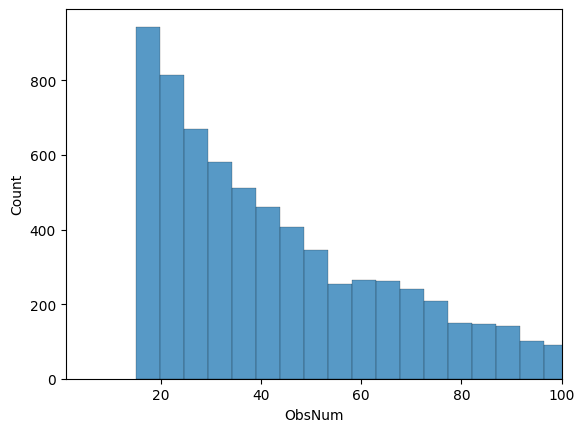

In [16]:
plotting = mutspec12.groupby(mutspec12['Species']).aggregate({'ObsNum' : 'sum'})
fig, ax = plt.subplots()
sns.histplot(plotting, x='ObsNum', ax=ax)
ax.set_xlim(1, 100)

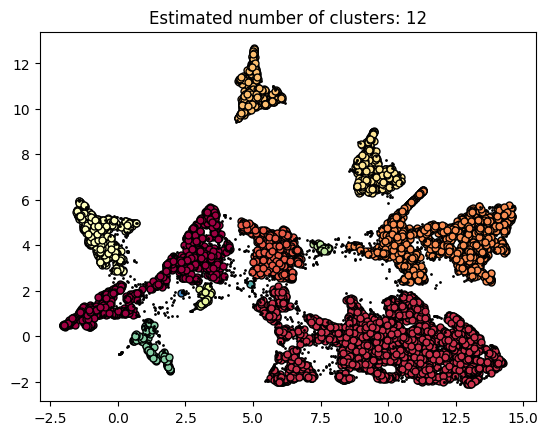

In [17]:
#DBSCAN: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
X = embed
db = DBSCAN(eps=0.3, min_samples=20).fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=5,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=1,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [18]:
# removing unnecessary clusters
orders_distribution = pd.DataFrame()
orders_distribution['Orders'] = df['Orders']
orders_distribution['Species'] = df['Species']
orders_distribution['Cluster'] = db.labels_
orders_distribution.drop(orders_distribution[orders_distribution.Cluster == -1].index, inplace=True)
to_remove = []
for k,v in Counter(orders_distribution['Cluster']).items():
    if v < 50:
        to_remove.append(k)

for v in to_remove:
    orders_distribution.drop(orders_distribution[orders_distribution.Cluster == v].index, inplace=True)

#getting rid of 4 major orders for future use
orders_distribution_without_4_majors = orders_distribution
orders_distribution_without_4_majors = orders_distribution_without_4_majors.loc[~((orders_distribution_without_4_majors['Orders'] == 'Lepidoptera_7088') | 
(orders_distribution_without_4_majors['Orders'] == 'Coleoptera_7041') | (orders_distribution_without_4_majors['Orders'] == 'Hymenoptera_7399') | 
(orders_distribution_without_4_majors['Orders'] == 'Diptera_7147'))]

In [19]:
# renaming orders that contribute less than 10% to distribution in respective clusters as 'Others'
order_and_cluster = []
for i in range(len(orders_distribution['Orders'])):
    order_and_cluster.append(f'{orders_distribution["Orders"].to_list()[i]}:{orders_distribution["Cluster"].to_list()[i]}')
cluster_counts = orders_distribution['Cluster'].value_counts().to_dict()
to_rename= {}
for order_cluster, count in Counter(order_and_cluster).items():
    if count/cluster_counts[int(order_cluster.split(':')[1])] <= 0.1:
        to_rename[order_cluster] = int(order_cluster.split(':')[1])
for order, cluster in to_rename.items():
    order = order.split(':')[0]
    orders_distribution['Orders'] = np.where((orders_distribution['Orders'] == order) & (orders_distribution['Cluster'] == cluster), 'Other', orders_distribution['Orders'])

#same for df without 4 major orders
order_and_cluster = []
for i in range(len(orders_distribution_without_4_majors['Orders'])):
    order_and_cluster.append(f'{orders_distribution_without_4_majors["Orders"].to_list()[i]}:{orders_distribution_without_4_majors["Cluster"].to_list()[i]}')
cluster_counts = orders_distribution_without_4_majors['Cluster'].value_counts().to_dict()
to_rename= {}
for order_cluster, count in Counter(order_and_cluster).items():
    if count/cluster_counts[int(order_cluster.split(':')[1])] <= 0.05:
        to_rename[order_cluster] = int(order_cluster.split(':')[1])
for order, cluster in to_rename.items():
    order = order.split(':')[0]
    orders_distribution_without_4_majors['Orders'] = np.where((orders_distribution_without_4_majors['Orders'] == order) & (orders_distribution_without_4_majors['Cluster'] == cluster), 'Other', orders_distribution_without_4_majors['Orders'])

/tmp/ipykernel_22375/467961664.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_distribution_without_4_majors['Orders'] = np.where((orders_distribution_without_4_majors['Orders'] == order) & (orders_distribution_without_4_majors['Cluster'] == cluster), 'Other', orders_distribution_without_4_majors['Orders'])


Text(37.97661111111111, 0.5, 'Relative number of Orders')

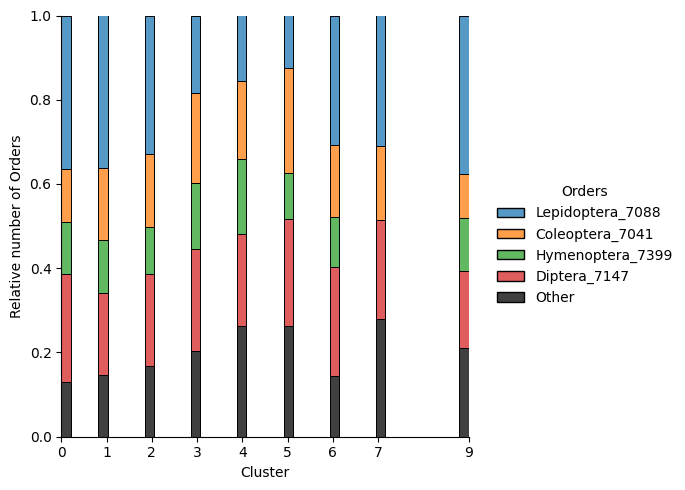

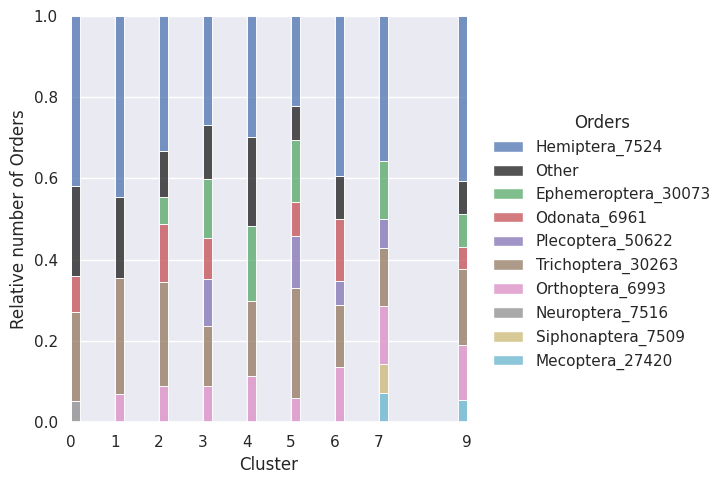

In [20]:
#plotting cluster distrebution w/ 4 major orders
unique = orders_distribution['Orders'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
palette.update({"Other":"k"})

sns.displot(orders_distribution, x='Cluster', hue='Orders', multiple='fill', palette=palette)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(orders_distribution['Cluster'].drop_duplicates().to_list())
plt.ylabel('Relative number of Orders')

#plotting cluster distrebution w/o 4 major orders
unique = orders_distribution_without_4_majors['Orders'].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
palette.update({"Other":"k"})

sns.displot(orders_distribution_without_4_majors, x='Cluster', hue='Orders', multiple='fill', palette=palette, binwidth=0.2)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(orders_distribution['Cluster'].drop_duplicates().to_list())
plt.ylabel('Relative number of Orders')

In [22]:
#adding cluster number into mutspec tables and exporting it for drawing mutspecs filtered by clusters (otherwise I have to downgrade umap and dbscan which leads to fucking up clusterization)
mutspec12['Cluster'] = np.nan
for sp_cluster_pair in orders_distribution.values:
    mutspec12['Cluster'] = np.where((mutspec12['Species'] == sp_cluster_pair[1]), sp_cluster_pair[2], mutspec12['Cluster'])
mutspec12 = mutspec12.dropna()
mutspec12.to_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutstep-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/mutspec12AddedClusters.tsv', sep='\t')


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 1 clusters is 231365.62
The within cluster sum of squares for 2 clusters is 112276.86
The within cluster sum of squares for 3 clusters is 77040.62


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 4 clusters is 51678.27
The within cluster sum of squares for 5 clusters is 37094.83
The within cluster sum of squares for 6 clusters is 28557.97


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 7 clusters is 22536.36
The within cluster sum of squares for 8 clusters is 18898.86
The within cluster sum of squares for 9 clusters is 16022.53
The within cluster sum of squares for 10 clusters is 13391.22


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 11 clusters is 10983.04
The within cluster sum of squares for 12 clusters is 10048.41


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 13 clusters is 9244.82
The within cluster sum of squares for 14 clusters is 8507.08


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 15 clusters is 7874.80
The within cluster sum of squares for 16 clusters is 7215.61


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 17 clusters is 6713.38


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 18 clusters is 6325.83


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The within cluster sum of squares for 19 clusters is 6001.94
The within cluster sum of squares for 20 clusters is 5742.39


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


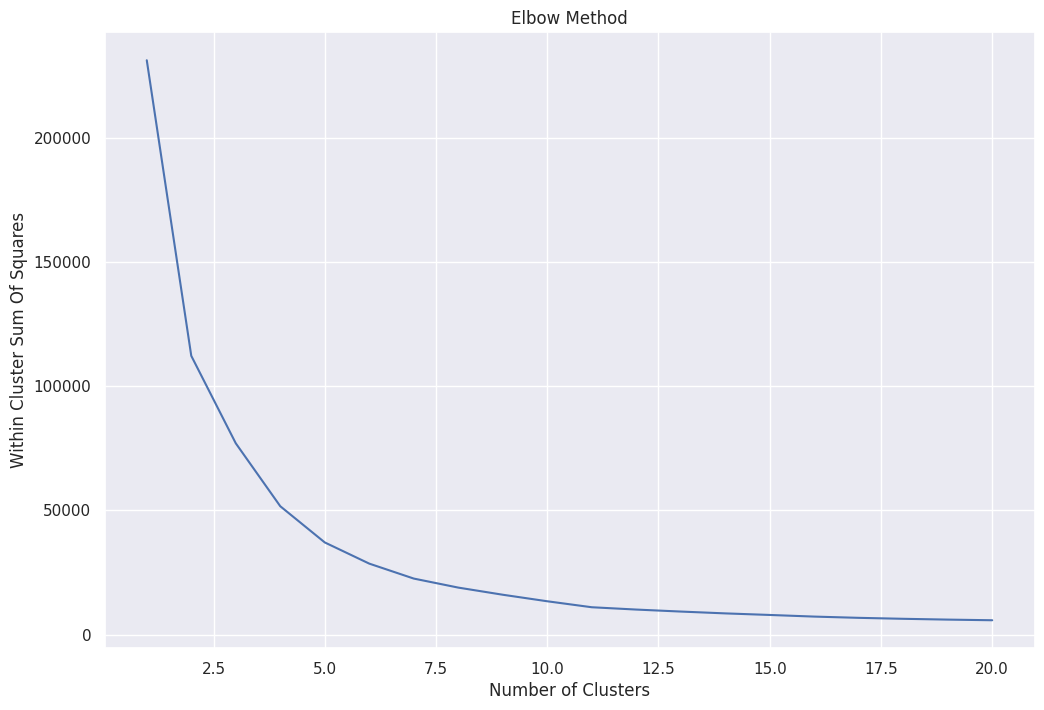

In [ ]:
# Create an empty dictionary to save the within cluster sum of square values
wcss = {} 
# Look through the number of clusters
for i in range(1,21):
  # Run kmeans model
  kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
  #Sum of squared distances of samples to their closest cluster center.
  wcss[i] = (kmeans.inertia_)
  # Print the within cluster sum of squares for each cluster number
  print(f'The within cluster sum of squares for {i} clusters is {wcss[i]:.2f}')

  # Visualization
plt.figure(figsize=(12,8))
plt.plot(list(wcss.keys()),list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum Of Squares')
plt.show()

/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 2 clusters is 0.469


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 3 clusters is 0.473


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 4 clusters is 0.494


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 5 clusters is 0.480


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 6 clusters is 0.468


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 7 clusters is 0.469


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 8 clusters is 0.475


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 9 clusters is 0.495


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 10 clusters is 0.500


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 11 clusters is 0.492


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 12 clusters is 0.487


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 13 clusters is 0.485


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 14 clusters is 0.481


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 15 clusters is 0.478


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 16 clusters is 0.479


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 17 clusters is 0.464


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 18 clusters is 0.456


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 19 clusters is 0.450


/home/gabs/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette score for 20 clusters is 0.446


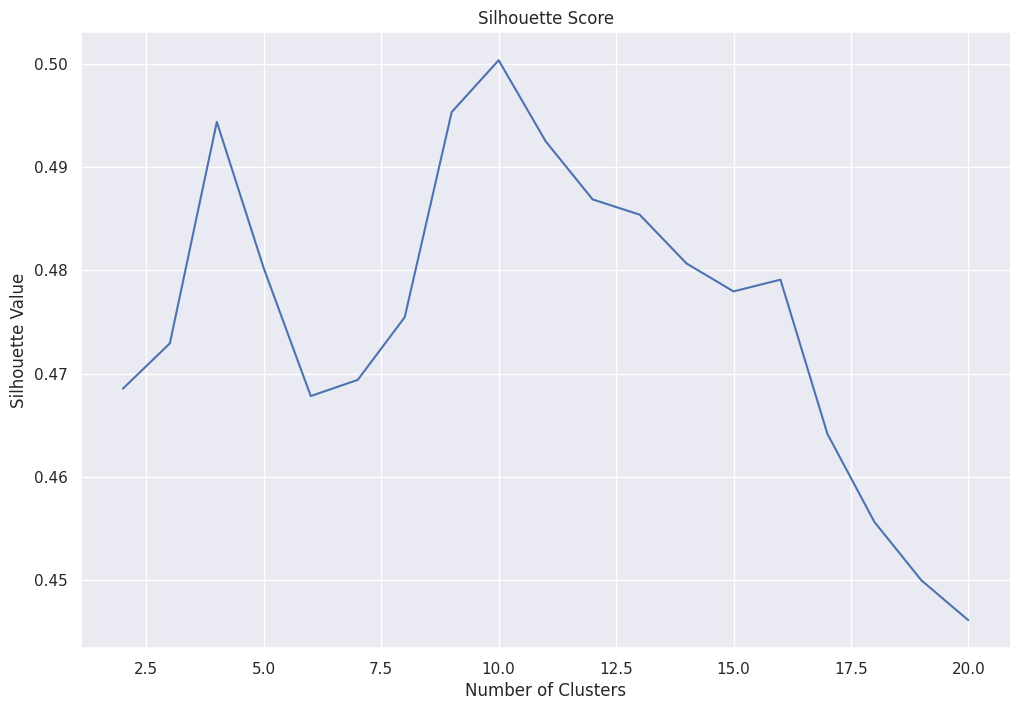

In [ ]:
# Create an empty dictionary for the Silhouette score
s_score = {} 
# Loop through the number of clusters
for i in range(2,21): # Note that the minimum number of clusters is 2
  # Fit kmeans clustering model for each cluster number
  kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
  # Make prediction
  classes = kmeans.predict(X)
  # Calculate Silhouette score
  s_score[i] = (silhouette_score(X, classes)) 
  # Print the Silhouette score for each cluster number
  print(f'The silhouette score for {i} clusters is {s_score[i]:.3f}') 
  # Visualization
plt.figure(figsize=(12,8))
plt.plot(list(s_score.keys()),list(s_score.values()))
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Value')
plt.show()